<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/chugh007/CreditCard_FraudDetection/blob/master/creditcardfraud.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [3]:
import urllib

PROJECT_ROOT="."
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/chugh007/CreditCard_FraudDetection/master/"
dataset_path = os.path.join(PROJECT_ROOT,"datasets","downloaded_dataset")
DATASET_URL = DOWNLOAD_ROOT + os.path.join("datasets","creditcard.tar.gz")
urllib.request.urlretrieve(DOWNLOAD_ROOT+"requirements.txt","downloaded_requirements.txt")
!pip install -r downloaded_requirements.txt


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import os
import tarfile
import urllib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit,train_test_split,StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
import joblib

In [3]:
def fetch_dataset(url=DATASET_URL,path=dataset_path):
    os.makedirs(dataset_path,exist_ok=True)
    tar_path = os.path.join(dataset_path,"creditcard.tar.gz")
    print("Downloading the dataset from {}".format(url))
    urllib.request.urlretrieve(url,tar_path)
    with tarfile.open(tar_path) as creditcard_tar:
        creditcard_tar.extractall(path=path)
    return pd.read_csv(os.path.join(path,"creditcard.csv"))



In [4]:
creditcard = fetch_dataset()
creditcard

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
creditcard

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
creditcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
creditcard['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

As we can see there are only 492 fraud cases among 284807 samples

In [8]:
creditcard.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Lets Analyse time first. In Data description Time contains the seconds elapsed between each transaction and the first transaction in the dataset. 

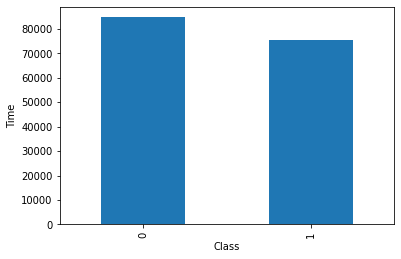

In [9]:
creditcard.groupby('Class')['Time'].median().plot.bar()
plt.xlabel('Class')
plt.ylabel('Time')
plt.show()

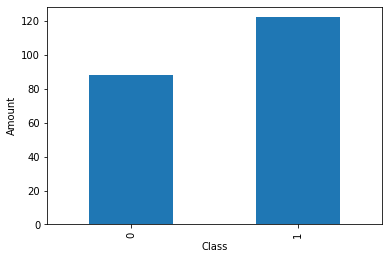

In [10]:
creditcard.groupby('Class')['Amount'].mean().plot.bar()
plt.xlabel('Class')
plt.ylabel('Amount')
plt.show()

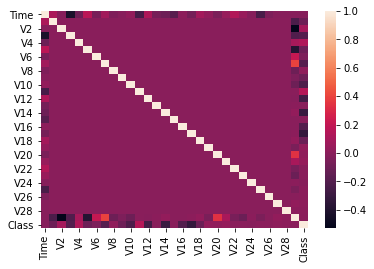

In [11]:
sns.heatmap(creditcard.corr())
plt.show()

For anomaly detection is important to have features in gaussian distribution , so we will check it by drawing histograms of the data

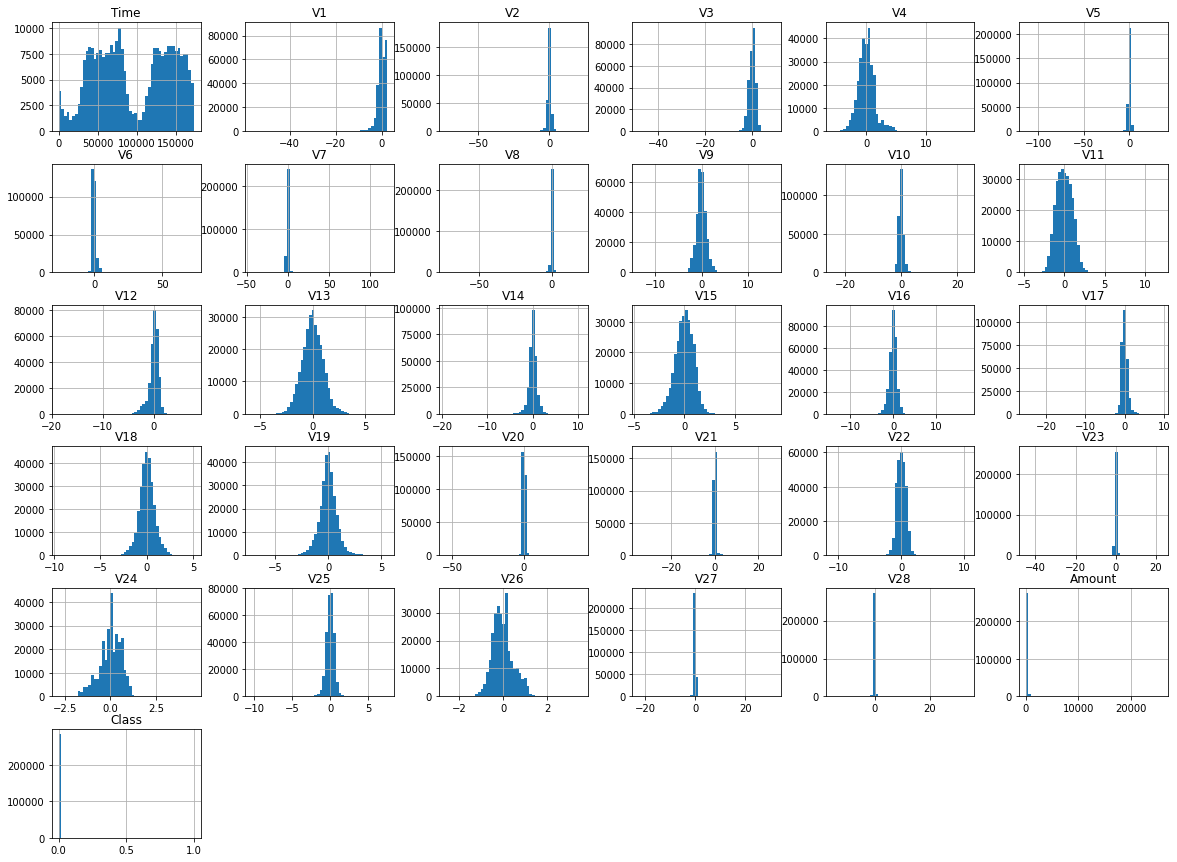

In [12]:
creditcard.hist(bins=50,figsize=(20,15))
plt.show()

 
## Anomaly detection

Based on Andrew Ng anomaly detection technique , we should put anomalous data in our test and validation set and not in training set . So here we will add 50% anomolous samples in test set and 50% in validation set

Lets divide the dataset in train and test set based on class.

In [13]:
#spliting only non-anomolous examples
credit_train,credit_testsplit = train_test_split(creditcard[creditcard['Class'] == 0],test_size=0.1,random_state=42)
credit_test,credit_val = train_test_split(credit_testsplit,test_size=0.5,random_state=42)
print("Train size {} \n Validation Size {}\n Test Size {}".format(
    credit_train.shape,credit_val.shape,credit_test.shape
))

Train size (255883, 31) 
 Validation Size (14216, 31)
 Test Size (14216, 31)


Now non-anomolous examples are split across train,test,validation sets .  Now we will take anomolous data and add  it to validation and test set in 50 % ratio

In [14]:
credit_test_anomolous,credit_val_anomolous = train_test_split(creditcard[creditcard['Class'] == 1],test_size=0.5,random_state=42)

credit_test = credit_test.append(credit_test_anomolous)
credit_val = credit_val.append(credit_val_anomolous)

print("Train size {} \n Validation Size {}\n Test Size {}".format(
    credit_train.shape,credit_val.shape,credit_test.shape
))

Train size (255883, 31) 
 Validation Size (14462, 31)
 Test Size (14462, 31)


In [15]:
for index,(name,data) in enumerate(zip(["train","validation","test"],[credit_train,credit_val,credit_test])):
    print("{} set : \n{}".format(name,data['Class'].value_counts()))
    print("-"*10)

train set : 
0    255883
Name: Class, dtype: int64
----------
validation set : 
0    14216
1      246
Name: Class, dtype: int64
----------
test set : 
0    14216
1      246
Name: Class, dtype: int64
----------


In [16]:
X_train,X_val,X_test,y_train,y_val,y_test = credit_train.drop('Class',axis=1),credit_val.drop('Class',axis=1),credit_test.drop('Class',axis=1),credit_train['Class'].copy(),credit_val['Class'].copy(),credit_test['Class'].copy()

X_train.shape

(255883, 30)

Now our dataset is ready and split between train,validation and test set.
We will now find a right number of clusters in GaussianMixtureModel using BIC and AIC curve.

NOTE : This finding a good n_components part can be skipped , as I have already trained the model for n_components=55 and saved on the disk.

In [16]:
bic = []
aic = []
for cluster in range(2,50):
    gm = GaussianMixture(n_components=cluster,verbose=10).fit(X_train)
    bic.append(gm.bic(X_train))
    aic.append(gm.aic(X_train))

Initialization 0
  Iteration 10	 time lapse 3.21851s	 ll change 1.24864
  Iteration 20	 time lapse 2.86750s	 ll change 0.00164
  Iteration 30	 time lapse 2.85534s	 ll change 0.00290
  Iteration 40	 time lapse 3.12698s	 ll change 0.00371
  Iteration 50	 time lapse 3.06995s	 ll change 0.03501
Initialization converged: True	 time lapse 17.83686s	 ll -32.42654
Initialization 0
  Iteration 10	 time lapse 5.59895s	 ll change 6.09192
Initialization converged: True	 time lapse 9.07916s	 ll 0.79376
Initialization 0
  Iteration 10	 time lapse 6.42679s	 ll change 1.73092
  Iteration 20	 time lapse 5.83275s	 ll change 0.00133
Initialization converged: True	 time lapse 12.84480s	 ll -10.22974
Initialization 0
  Iteration 10	 time lapse 8.48950s	 ll change 1.57509
  Iteration 20	 time lapse 7.56167s	 ll change 0.12330
  Iteration 30	 time lapse 7.57110s	 ll change 0.00257
  Iteration 40	 time lapse 7.56994s	 ll change 0.00082
Initialization converged: True	 time lapse 31.19232s	 ll 7.57483
Initializ

  Iteration 20	 time lapse 54.52732s	 ll change 0.22971
  Iteration 30	 time lapse 55.32158s	 ll change 0.04096
  Iteration 40	 time lapse 56.19097s	 ll change 0.02275
  Iteration 50	 time lapse 55.95441s	 ll change 0.01303
Initialization converged: True	 time lapse 304.41019s	 ll 26.53321
Initialization 0
  Iteration 10	 time lapse 68.26661s	 ll change 2.24361
  Iteration 20	 time lapse 58.06148s	 ll change 0.04771
  Iteration 30	 time lapse 57.25022s	 ll change 0.02358
  Iteration 40	 time lapse 60.53133s	 ll change 0.00690
  Iteration 50	 time lapse 58.20197s	 ll change 0.00191
  Iteration 60	 time lapse 58.93610s	 ll change 0.00590
Initialization converged: True	 time lapse 413.55120s	 ll 26.12376
Initialization 0
  Iteration 10	 time lapse 63.37317s	 ll change 1.14966
  Iteration 20	 time lapse 59.82243s	 ll change 0.18085
  Iteration 30	 time lapse 59.73090s	 ll change 0.01989
  Iteration 40	 time lapse 64.85442s	 ll change 0.02846
Initialization converged: True	 time lapse 301.8

  Iteration 50	 time lapse 96.17649s	 ll change 0.00222
  Iteration 60	 time lapse 95.36949s	 ll change 0.00242
Initialization converged: True	 time lapse 665.61097s	 ll 30.11044
Initialization 0
  Iteration 10	 time lapse 105.91299s	 ll change 1.64128
  Iteration 20	 time lapse 98.27062s	 ll change 0.39671
  Iteration 30	 time lapse 97.96508s	 ll change 0.07427
  Iteration 40	 time lapse 97.93385s	 ll change 0.00920
  Iteration 50	 time lapse 97.87173s	 ll change 0.00847
Initialization converged: True	 time lapse 547.70350s	 ll 32.96414
Initialization 0
  Iteration 10	 time lapse 113.19131s	 ll change 1.22159
  Iteration 20	 time lapse 105.47829s	 ll change 0.04380
  Iteration 30	 time lapse 103.97977s	 ll change 0.01917
  Iteration 40	 time lapse 104.22569s	 ll change 0.02001
  Iteration 50	 time lapse 105.36942s	 ll change 0.01394
Initialization converged: True	 time lapse 596.53236s	 ll 29.55703
Initialization 0
  Iteration 10	 time lapse 112.03372s	 ll change 0.73452
  Iteration 2

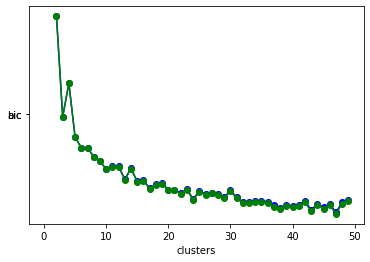

In [17]:
plt.plot(range(2,50),bic,"bo-","bic")
plt.plot(range(2,50),aic,"go-","aic")
plt.xlabel("clusters")
plt.show()

In [18]:
np.argmin(bic)

45

we got min value on 45 , lets explore a few more clusters,to confirm

In [22]:
gauss = []
for cluster in range(50,60):
    gm = GaussianMixture(n_components=cluster,verbose=10).fit(X_train)
    bic.append(gm.bic(X_train))
    aic.append(gm.aic(X_train))
    gauss.append(gm)

Initialization 0
  Iteration 10	 time lapse 112.97505s	 ll change 1.46603
  Iteration 20	 time lapse 104.15343s	 ll change 0.38475
  Iteration 30	 time lapse 104.84048s	 ll change 0.03312
  Iteration 40	 time lapse 104.73951s	 ll change 0.00292
Initialization converged: True	 time lapse 511.01862s	 ll 31.97290
Initialization 0
  Iteration 10	 time lapse 116.15773s	 ll change 1.77349
  Iteration 20	 time lapse 107.45146s	 ll change 0.26155
  Iteration 30	 time lapse 107.41089s	 ll change 0.00915
  Iteration 40	 time lapse 107.13225s	 ll change 0.00157
Initialization converged: True	 time lapse 481.01413s	 ll 30.43286
Initialization 0
  Iteration 10	 time lapse 119.91587s	 ll change 1.90684
  Iteration 20	 time lapse 110.60107s	 ll change 0.14264
  Iteration 30	 time lapse 111.39664s	 ll change 0.02903
  Iteration 40	 time lapse 110.35225s	 ll change 0.01932
Initialization converged: True	 time lapse 552.29454s	 ll 30.59573
Initialization 0
  Iteration 10	 time lapse 122.01811s	 ll chang

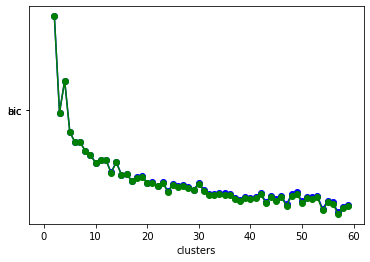

In [23]:
plt.plot(range(2,60),bic,"bo-","bic")
plt.plot(range(2,60),aic,"go-","aic")
plt.xlabel("clusters")
plt.show()

We will take n_components as 55 . We could have explored few more values but it takes a lot of time to train GaussianMixture on the training set. Alternatively BayesianGaussianMixture also could be used will large value of n_components , but it takes even more longer time .  

I have already trained the model and saved on the disk, so instead of wasting time I will download it.

In [56]:
urllib.request.urlretrieve(DOWNLOAD_ROOT+os.path.join("models","gauss_mixture_model_55.pkl"),"downloaded_model.pkl")
gm_55 = joblib.load("downloaded_model.pkl")
gm_55

GaussianMixture(n_components=55, verbose=6)

In [22]:
densities = gm_55.score_samples(X_train) # log of PDF 
densities[:10]

array([  9.3953403 ,   0.50888929,  55.3684695 ,  24.05413572,
       -44.5965609 ,  21.71095325,  -9.06160869,  56.30704175,
        23.87583628,  58.54518512])

In [23]:
densities_threshold = np.percentile(densities,1e-1)
densities_threshold

-71.18815525802671

In [24]:
y_pred = (gm_55.score_samples(X_val) < densities_threshold).astype(np.int8)
roc_auc_score(y_val,y_pred)

0.8531661336590856

In [25]:
credit_val['Class'].value_counts()

0    14216
1      246
Name: Class, dtype: int64

In [ ]:
def search_good_density_threshold(gm_model,percentile_threshold,validation_data):
    X_val,y_val = validation_data[0],validation_data[1]
    roc_auc = []
    density_thresholds = []
    for threshold in percentile_threshold:
        densities = gm_model.score_samples(X_val)
        densities_threshold = np.percentile(densities,threshold)
        y_pred = (densities < densities_threshold).astype(np.int8)
        roc_score = roc_auc_score(y_val,y_pred)
        roc_auc.append(roc_score)
        density_thresholds.append(densities_threshold)
        accuracy = accuracy_score(y_val,y_pred)
        recall = recall_score(y_val,y_pred)
        print("For threshold value {} roc auc score -> {},acc: {},recall : {}".format(threshold,roc_score,accuracy,recall))
    optimal_density_threshold = density_thresholds[np.argmax(roc_auc)]
    best_roc = roc_auc[np.argmax(roc_auc)]
    best_percentile = percentile_threshold[np.argmax(roc_auc)]
    print("Best roc {} and best threshold = {} and best percentile {}".format(best_roc,optimal_density_threshold,best_percentile))
    return density_thresholds[np.argmax(roc_auc)]
    
        

In [59]:
optimal_density_threshold = search_good_density_threshold(gm_55,
                                                          np.linspace(1e-1,5,100),
                                                          validation_data=(X_val,y_val))
optimal_density_threshold

For threshold value 0.1 roc auc score -> 0.5284201129152541,acc: 0.9838888120591897,recall : 0.056910569105691054
For threshold value 0.14949494949494951 roc auc score -> 0.5385123712660874,acc: 0.9840962522472687,recall : 0.07723577235772358
For threshold value 0.198989898989899 roc auc score -> 0.5506723215797155,acc: 0.9844419858940672,recall : 0.1016260162601626
For threshold value 0.2484848484848485 roc auc score -> 0.5648999638561383,acc: 0.9849260129995852,recall : 0.13008130081300814
For threshold value 0.297979797979798 roc auc score -> 0.5811601264577643,acc: 0.9854791868344628,recall : 0.16260162601626016
For threshold value 0.3474747474747475 roc auc score -> 0.5953877687341871,acc: 0.9859632139399807,recall : 0.1910569105691057
For threshold value 0.396969696969697 roc auc score -> 0.6096154110106098,acc: 0.9864472410454985,recall : 0.21951219512195122
For threshold value 0.44646464646464656 roc auc score -> 0.6238430532870326,acc: 0.9869312681510165,recall : 0.24796747967

-36.9582874568038

So we got a good percentile threshold to use as 2.82 . Lets try to search for any good values between 2.80 and 2.85

In [60]:
optimal_density_threshold = search_good_density_threshold(gm_55,
                                                          np.linspace(2.80,2.85,20),
                                                          validation_data=(X_val,y_val))
optimal_density_threshold

For threshold value 2.8 roc auc score -> 0.9117000311111721,acc: 0.9834739316830314,recall : 0.8373983739837398
For threshold value 2.802631578947368 roc auc score -> 0.9116648594735807,acc: 0.9834047849536717,recall : 0.8373983739837398
For threshold value 2.805263157894737 roc auc score -> 0.9116648594735807,acc: 0.9834047849536717,recall : 0.8373983739837398
For threshold value 2.807894736842105 roc auc score -> 0.9136973797987838,acc: 0.9834739316830314,recall : 0.8414634146341463
For threshold value 2.8105263157894735 roc auc score -> 0.9136973797987838,acc: 0.9834739316830314,recall : 0.8414634146341463
For threshold value 2.813157894736842 roc auc score -> 0.9136973797987838,acc: 0.9834739316830314,recall : 0.8414634146341463
For threshold value 2.8157894736842106 roc auc score -> 0.9136622081611925,acc: 0.9834047849536717,recall : 0.8414634146341463
For threshold value 2.818421052631579 roc auc score -> 0.9136622081611925,acc: 0.9834047849536717,recall : 0.8414634146341463
For 

-37.18616469970186

In [62]:
densities_threshold = optimal_density_threshold
y_test_pred = (gm_55.score_samples(X_test) < densities_threshold).astype(np.int8)
roc_auc_score(y_test,y_test_pred)

0.9025851439577985